In [1]:
import re
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time
path_root = '../anomaly_detection/'
sys.path.append(str(path_root))
from detectors import InfluenceFunctionDetector

In [3]:
dataset = "SMAP_MSL"
data_path = Path("../data/multivariate/") / dataset
test_df = pd.read_csv(data_path/"labeled_anomalies.csv")
smap_df = test_df.loc[test_df.spacecraft == "SMAP"]
df = smap_df.loc[smap_df.chan_id != "P-2"]

#### Univariate

In [4]:
class Config:
    def __init__(self):
        self.win_size = 25
        self.data_path = '../anomaly_detection/data_processed/SMAP'
        self.dimensions = [0]
        self.dataset = 'SMAP'
        self.verbose = False
        
df = smap_df.loc[smap_df.chan_id != "P-2"]
config = Config()
detector = InfluenceFunctionDetector(config)

anomaly ratio is 8.795 %.
start detection for channel P-1 ..
Block length: 25


Compute TimeInf: 100%|██████████| 8480/8480 [00:00<00:00, 114645.75it/s]


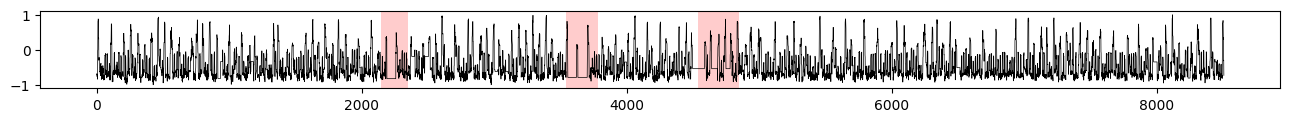

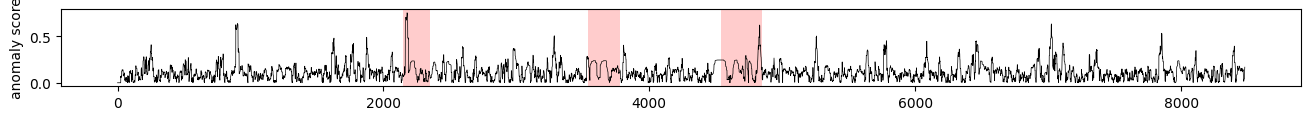

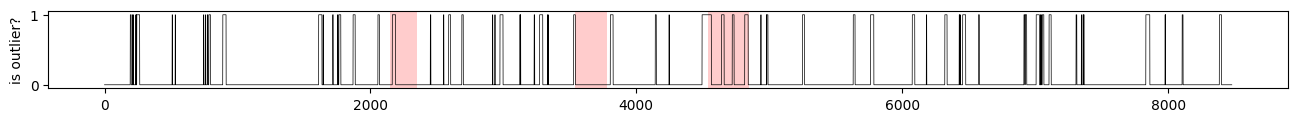

Threshold:0.24
Precision: 0.16 Recall: 0.16 F1: 0.16 AUC: 0.65


In [13]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict = {}, {}, {}, {}
time_dict = {}

for channel in df.chan_id.iloc:

    if config.dimensions is not None:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")[:,config.dimensions]
    else:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")

    seq_len = len(ts_test)
    anomaly_seqs = df.loc[df.chan_id == channel].anomaly_sequences.to_numpy().item()
    anomaly_seqs = re.findall(r'\d+', anomaly_seqs)
    anomaly_intervals = []
    for i in list(range(0, len(anomaly_seqs), 2)):
        anomaly_intervals.append(anomaly_seqs[i:i+2])
    anomaly_intervals = np.array(anomaly_intervals).astype(int)

    ground_truth = np.zeros(ts_test.shape[0])
    plt.figure(figsize=(16,1))
    plt.plot(ts_test, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.

    anomaly_len = sum(ground_truth)
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = min(anomaly_ratio,0.5)) # contamination has to be inthe range (0.0,0.5]
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)
    
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(anomaly_scores)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("anomaly score")
    plt.show()
    
    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio) #
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("is outlier?")
    plt.show()
    
    prec, rec, f1, auc = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    time_dict.update({channel: elapsed_time})

    break

smap_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision": prec_dict,
    "Recall": rec_dict,
    "F1": f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smap_metrics.insert(0, "Dataset", smap_metrics.index)
smap_metrics.reset_index(drop = True, inplace = True)

#### Multivariate

In [14]:
dataset = "SMD"
data_path = Path("../data/multivariate/") / dataset
machine_names = [Path(f).stem for f in listdir(data_path/"test") if isfile(join(data_path/"test", f))]

class Config:
    def __init__(self):
        self.win_size = 25
        self.data_path = '../anomaly_detection/data_processed/SMD'
        self.dataset = 'SMD'
        self.seed = 42
        self.verbose = False
        self.dimensions = None
        
config = Config()
detector = InfluenceFunctionDetector(config)

start detection for server machine-3-4 ..


/tmp/ipykernel_1488775/503209541.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,1))


anomaly ratio is 4.125 %.
start detection for channel machine-3-4 ..
Block length: 25


Compute TimeInf: 100%|██████████| 23662/23662 [00:00<00:00, 179564.43it/s]


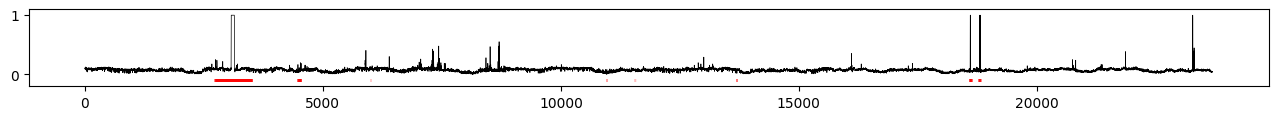

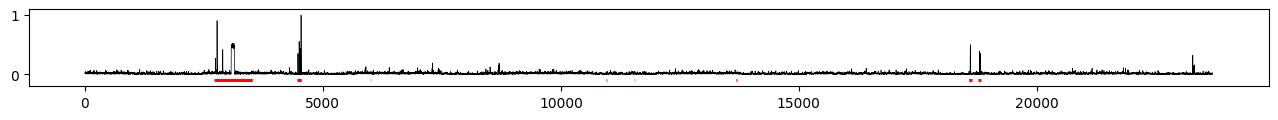

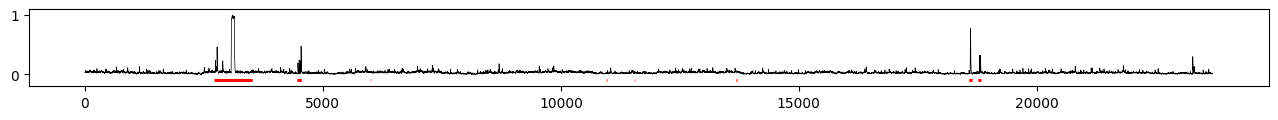

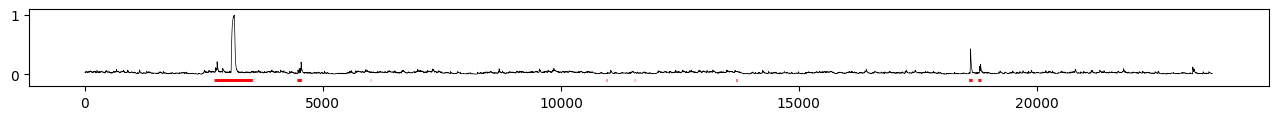

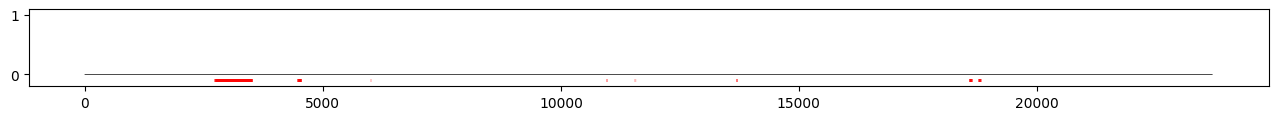

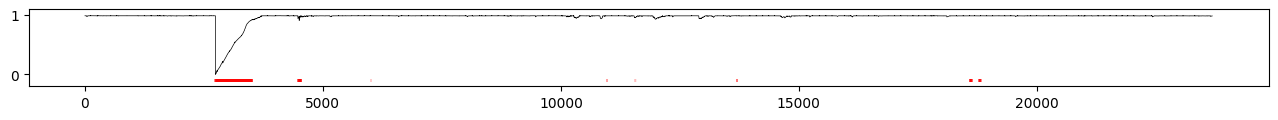

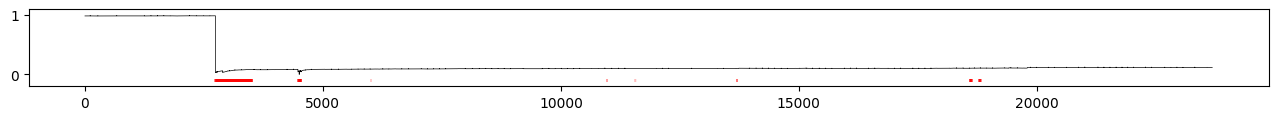

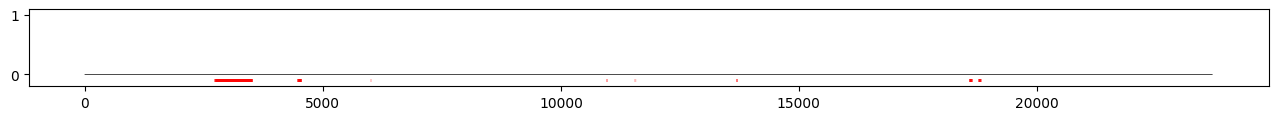

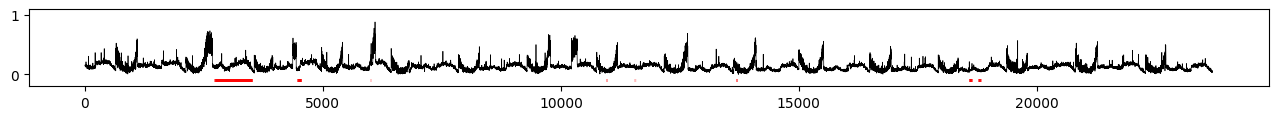

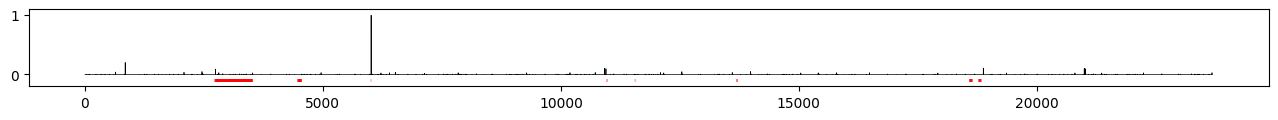

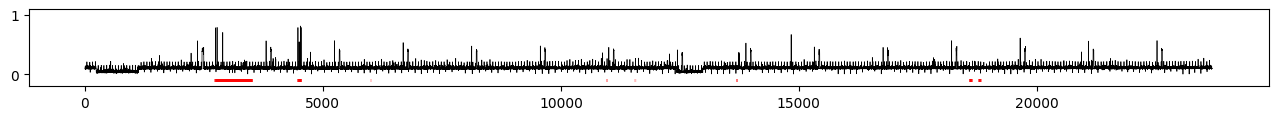

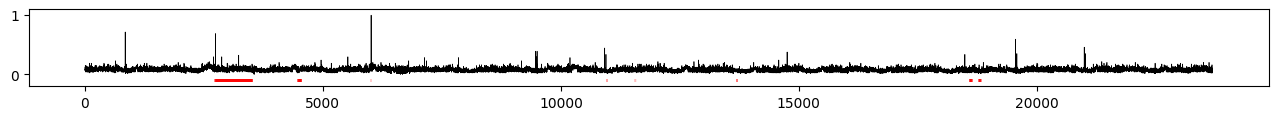

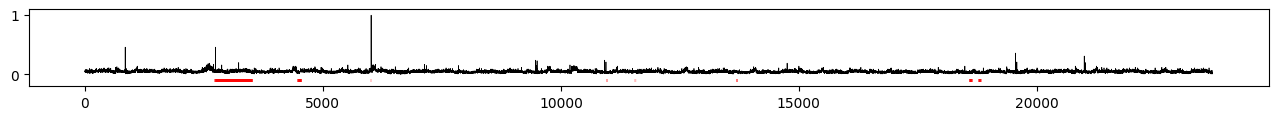

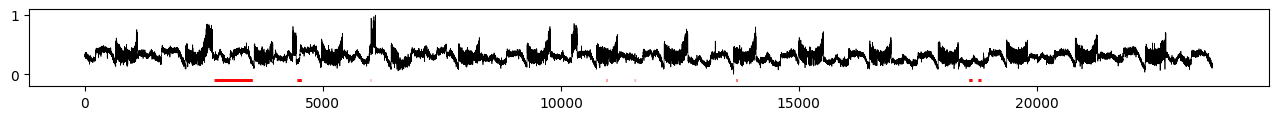

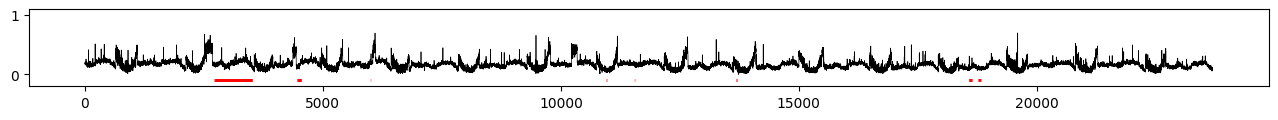

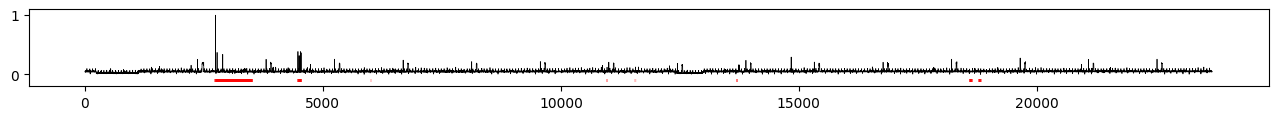

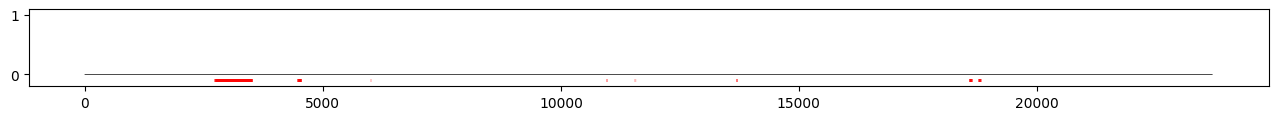

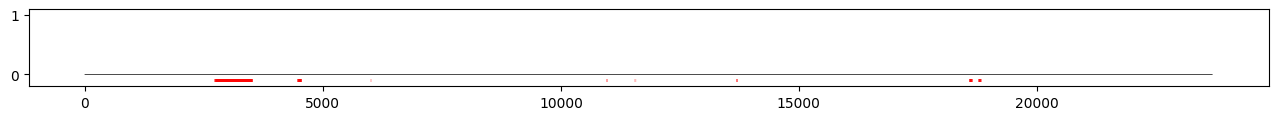

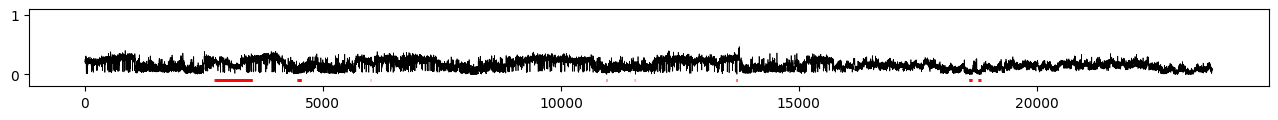

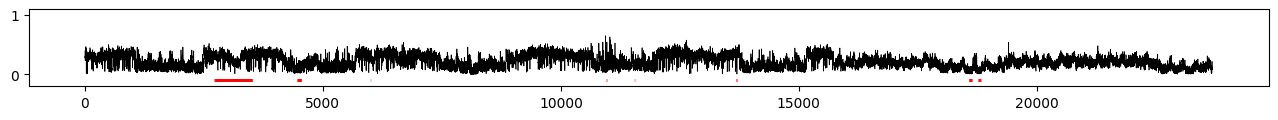

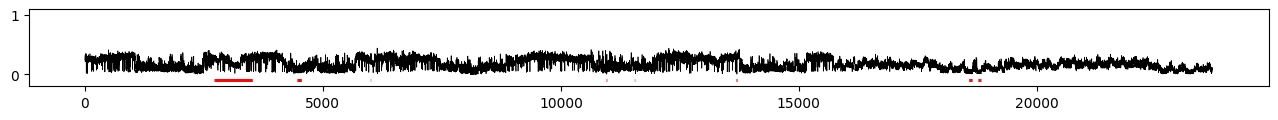

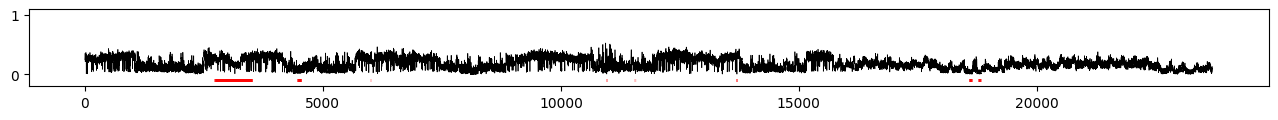

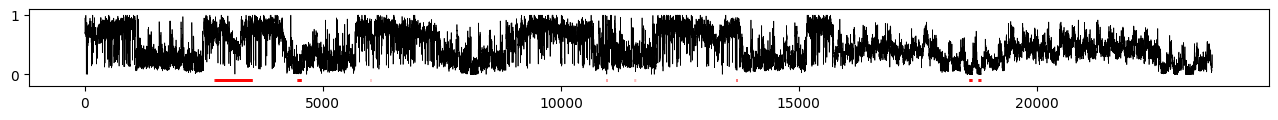

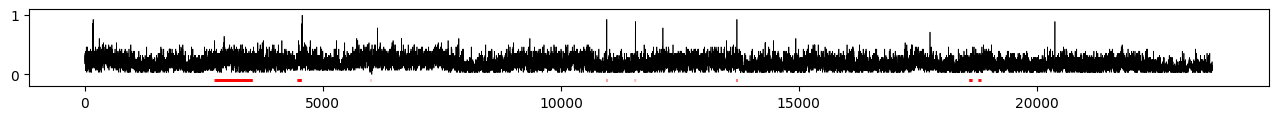

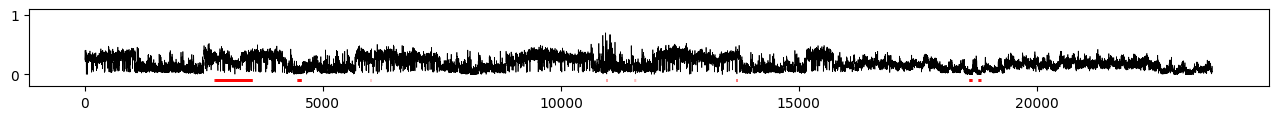

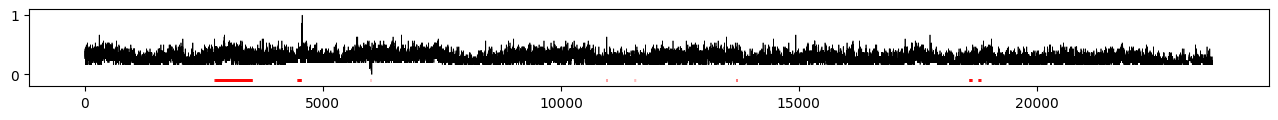

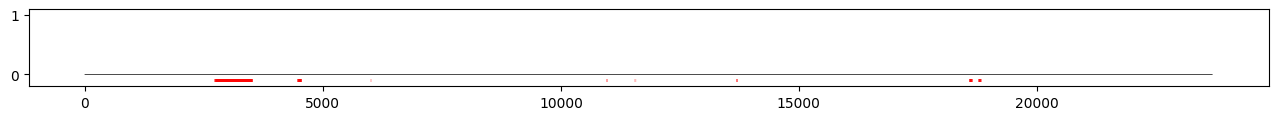

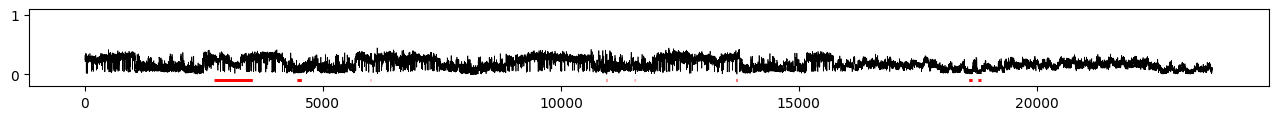

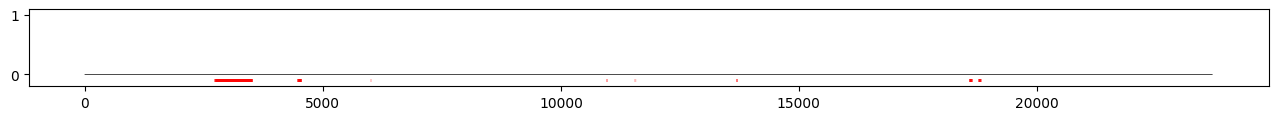

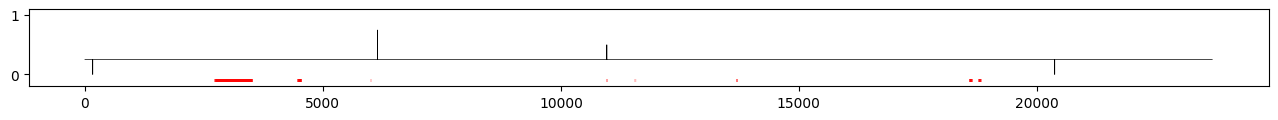

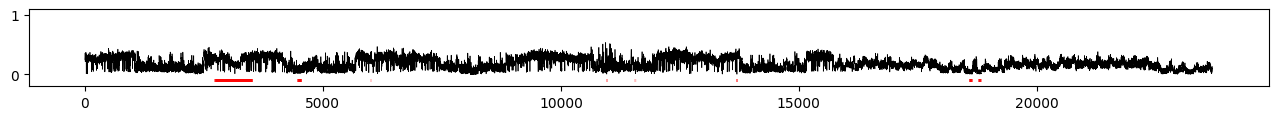

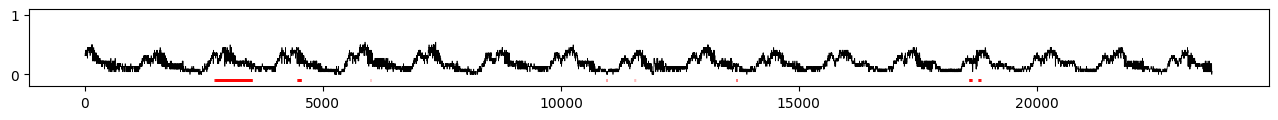

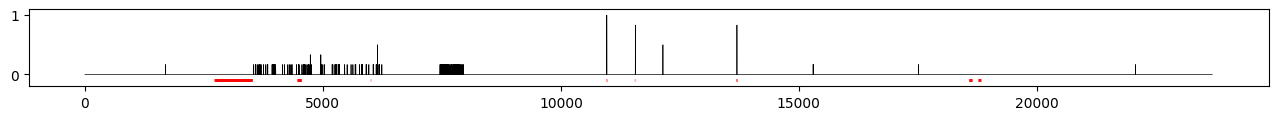

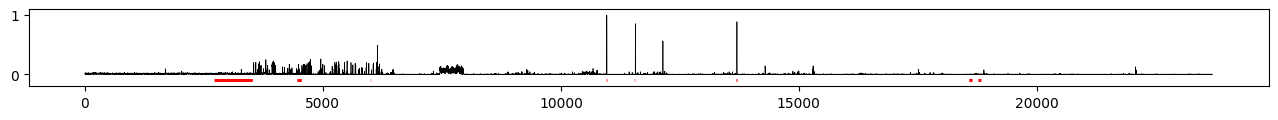

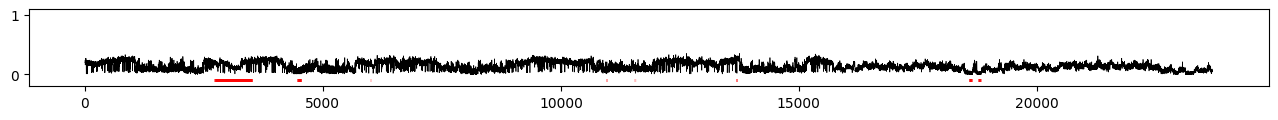

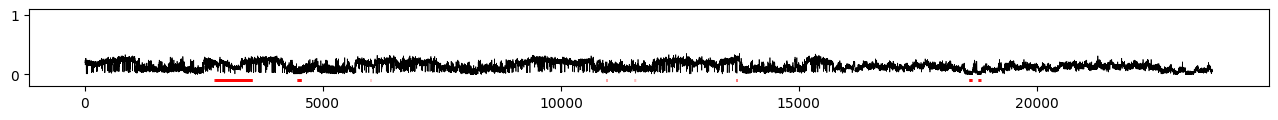

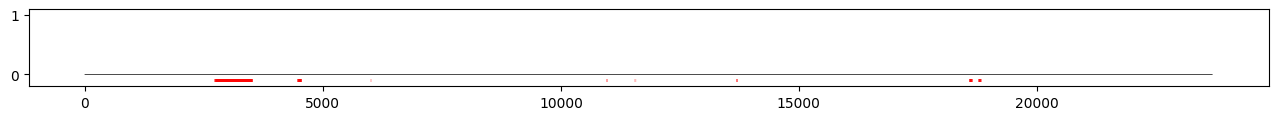

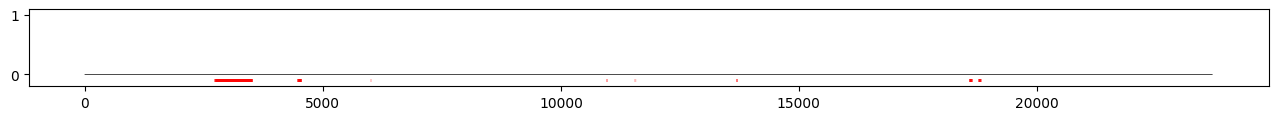

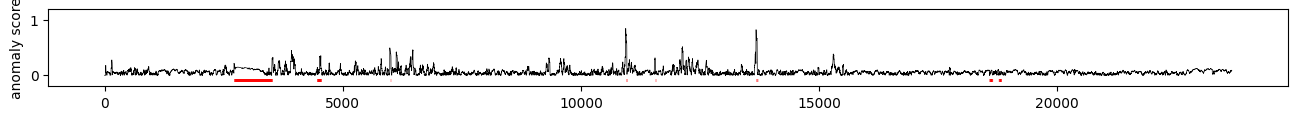

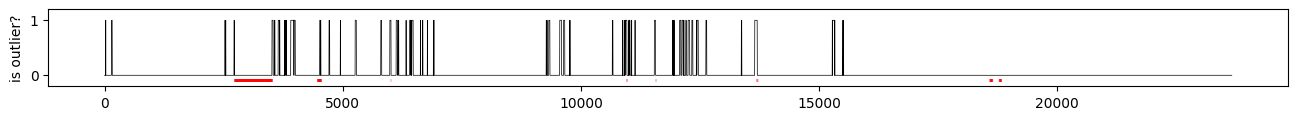

Threshold:0.18
Precision: 0.03 Recall: 0.03 F1: 0.03 AUC: 0.74


In [15]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict = {}, {}, {}, {}
time_dict = {}

for channel in machine_names:

    print(f"start detection for server {channel} ..")
    ts_test = pd.read_csv(data_path/"test"/f"{channel}.txt", sep=",", header=None).to_numpy()
    seq_len, n_dim = ts_test.shape
    ground_truth = pd.read_csv(data_path/"test_label"/f"{channel}.txt", sep=",", header=None).to_numpy()
    anomaly_points = np.where(ground_truth == 1)[0]

    for ts in ts_test.T:
        plt.figure(figsize=(16,1))
        plt.plot(ts, c="k", linewidth=.5)
        plt.eventplot(anomaly_points, lineoffsets=-0.1, color='red', linelengths=0.05, linewidths=0.1)
        plt.ylim(-0.2, 1.1)

    anomaly_len = sum(ground_truth)[0]
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = anomaly_ratio)
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)

    plt.figure(figsize=(16,1))
    loos_viz = np.ones_like(ts_test.T[0]) * np.nan
    loos_viz[:len(anomaly_scores)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    plt.eventplot(anomaly_points, lineoffsets=-0.1, color='red', linelengths=0.05, linewidths=0.1)
    plt.ylim(-0.2, 1.2)
    plt.ylabel("anomaly score")
    plt.show()

    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio)

    plt.figure(figsize=(16,1))
    loos_viz = np.ones_like(ts_test.T[0]) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    plt.eventplot(anomaly_points, lineoffsets=-0.1, color='red', linelengths=0.05, linewidths=0.1)
    plt.ylim(-0.2, 1.2)
    plt.ylabel("is outlier?")
    plt.show()

    prec, rec, f1, auc = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})    
    time_dict.update({channel: elapsed_time})
    
    break 

smd_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision": prec_dict,
    "Recall": rec_dict,
    "F1": f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smd_metrics.insert(0, "Dataset", smd_metrics.index)
smd_metrics.reset_index(drop = True, inplace = True)